In [2]:
import pandas as pd
import numpy as np
import time
import torch
import torch.nn.functional as F
import torch.nn as nn 
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [42]:
transform = transforms.ToTensor()
for i in range(1,3): print(i)

1
2


In [4]:
train_data = datasets.CIFAR10(root = "../Data", train = True, transform = transform, download = True)
test_data = datasets.CIFAR10(root = "../Data", train = False, transform = transform, download = True)

Files already downloaded and verified
Files already downloaded and verified


In [23]:
from time import time
import multiprocessing as mp
for num_workers in range(0, mp.cpu_count()-8, 2):  
    train_loader = DataLoader(train_data,shuffle=True,num_workers=num_workers,batch_size=10,pin_memory=True)
    start = time()
    for epoch in range(1, 3):
        for i, data in enumerate(train_loader, 0):
            pass
    end = time()
    print("Finish with:{} second, num_workers={}".format(end - start, num_workers))

Finish with:13.355018615722656 second, num_workers=0
Finish with:11.731279611587524 second, num_workers=2
Finish with:12.982593774795532 second, num_workers=4
Finish with:17.254440784454346 second, num_workers=6


In [24]:
torch.manual_seed(53)
st = time()

train_loader = DataLoader(train_data, batch_size = 10, shuffle = True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_data, batch_size = 10, shuffle = False, num_workers=4, pin_memory=True)
print(time()-st,mp.cpu_count()
     )

0.0 16


In [25]:
for image, label in train_loader:
    break

In [26]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']
image.shape


torch.Size([10, 3, 32, 32])

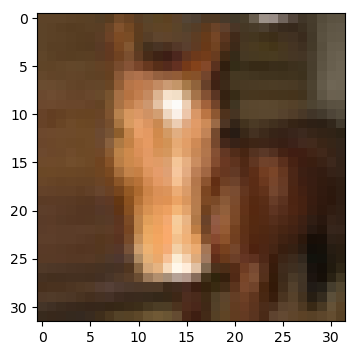

In [27]:
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(image[0], (1,2,0)))

labels: [    7     4     8     3     7     3     8     5     1     8]
label names: horse  deer  ship   cat horse   cat  ship   dog   car  ship


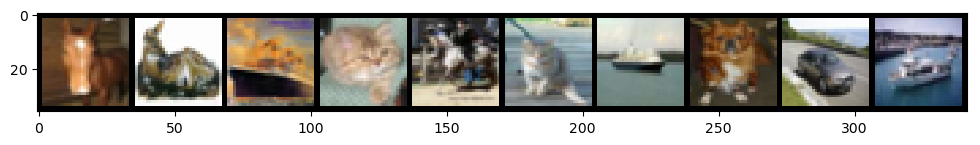

In [28]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array
print("labels:", label[:12].numpy())
print("label names:", *np.array([class_names[i] for i in label[:12]]))

im = make_grid(image[:12], nrow=12)
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))


In [29]:
class CNNmodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, 3, 1)
        self.conv2 = nn.Conv2d(10, 26, 3, 1)
        self.fc1 = nn.Linear(6*6*26, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 6*6*26)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [30]:
"""
in--conv6--relu--pool--conv16--relu--pool--fc1--fc2--out
32,32--3030--1515--1313--6*6*16--fc1
"""

'\nin--conv6--relu--pool--conv16--relu--pool--fc1--fc2--out\n32,32--3030--1515--1313--6*6*16--fc1\n'

In [31]:
torch.manual_seed(53)
model = CNNmodel()
model
gpumodel = model.cuda()


In [32]:
gpumodel

CNNmodel(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 26, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=936, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [33]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [34]:
print(count_parameters(model))
next(gpumodel.parameters()).is_cuda

   270
    10
  2340
    26
112320
   120
 10080
    84
   840
    10
______
126100
None


True

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [36]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        X_train, y_train = X_train.cuda(), y_train.cuda()
        # Apply the model
        y_pred = gpumodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/50000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()  
            # Apply the model
            y_val = gpumodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch: 1000 [ 10000/50000]  loss: 1.21996903  accuracy:  28.550%
epoch:  0  batch: 2000 [ 20000/50000]  loss: 1.03686404  accuracy:  35.135%
epoch:  0  batch: 3000 [ 30000/50000]  loss: 1.42408776  accuracy:  38.893%
epoch:  0  batch: 4000 [ 40000/50000]  loss: 1.73766804  accuracy:  41.590%
epoch:  0  batch: 5000 [ 50000/50000]  loss: 0.98018253  accuracy:  43.726%
epoch:  1  batch: 1000 [ 10000/50000]  loss: 1.30298924  accuracy:  53.820%
epoch:  1  batch: 2000 [ 20000/50000]  loss: 1.08239663  accuracy:  54.990%
epoch:  1  batch: 3000 [ 30000/50000]  loss: 0.99774903  accuracy:  55.817%
epoch:  1  batch: 4000 [ 40000/50000]  loss: 0.52322954  accuracy:  56.383%
epoch:  1  batch: 5000 [ 50000/50000]  loss: 1.59370184  accuracy:  56.846%
epoch:  2  batch: 1000 [ 10000/50000]  loss: 1.13155675  accuracy:  60.960%
epoch:  2  batch: 2000 [ 20000/50000]  loss: 1.25861049  accuracy:  60.910%
epoch:  2  batch: 3000 [ 30000/50000]  loss: 1.06993926  accuracy:  60.827%
epoch:  2  b

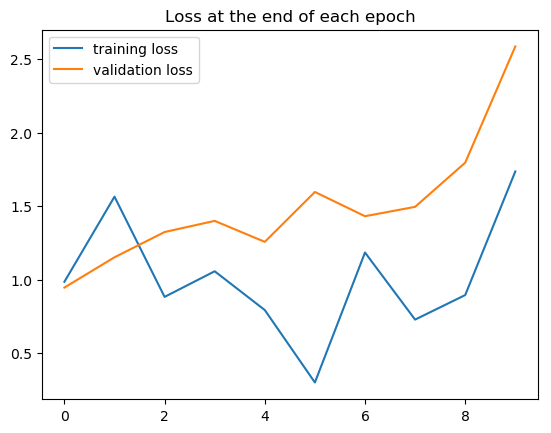

In [28]:
train_losses = [p.cpu().detach().numpy() for p in train_losses]
test_losses = [p.cpu().detach().numpy() for p in test_losses]

plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

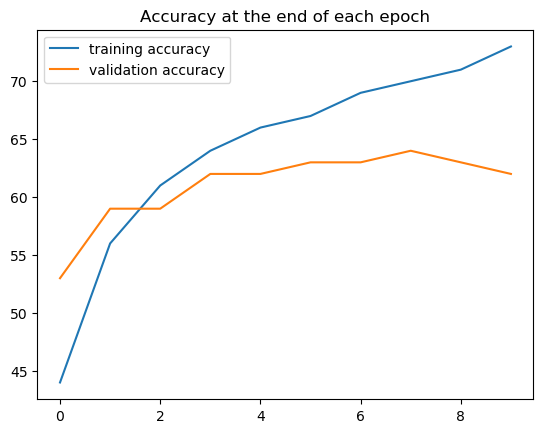

In [31]:
plt.plot([t.cpu()/500 for t in train_correct], label='training accuracy')
plt.plot([t.cpu()/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [32]:
print(test_correct) # contains the results of all 10 epochs
print()
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%') # print the most recent result as a percent

[tensor(5356, device='cuda:0'), tensor(5939, device='cuda:0'), tensor(5918, device='cuda:0'), tensor(6270, device='cuda:0'), tensor(6298, device='cuda:0'), tensor(6341, device='cuda:0'), tensor(6367, device='cuda:0'), tensor(6405, device='cuda:0'), tensor(6387, device='cuda:0'), tensor(6252, device='cuda:0')]

Test accuracy: 62.520%


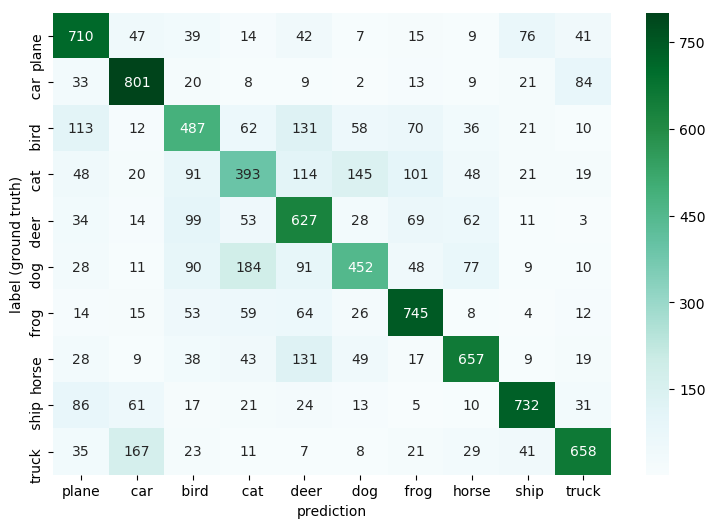

In [61]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

In [62]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

3738

In [63]:
r = 8   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

Index: [    1     2     4     8    12    15    17    19]
Label: [    8     8     6     3     5     8     7     6]
Class:   ship  ship  frog   cat   dog  ship horse  frog

Guess: [    1     1     4     4     6     0     3     4]
Class:    car   car  deer  deer  frog plane   cat  deer


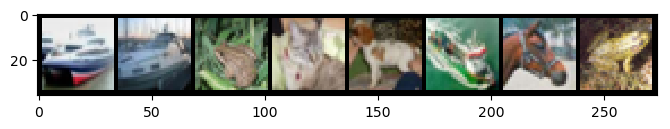

In [64]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

nextrow = next(row)
lbls = y_test.index_select(0,torch.tensor(nextrow)).numpy()
gues = predicted.index_select(0,torch.tensor(nextrow)).numpy()
print("Index:", nextrow)
print("Label:", lbls)
print("Class: ", *np.array([class_names[i] for i in lbls]))
print()
print("Guess:", gues)
print("Class: ", *np.array([class_names[i] for i in gues]))

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(8,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [65]:
torch.cuda.is_available()

True